# About The Dataset
- based on the different features (properties of the particle) that a telescope records, we are trying to build a model for predicting whether the particle that is been looked at is Gamma or Hadron.
- The data is from: https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Preparing the dataset

In [8]:
cols= ['fLenth', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df= pd.read_csv(r'Datasets\magic04.data',names=cols)
df.head()

,fLenth,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [ ]:
df['class'].value_counts() # I might need to balance the dataset later (the training set)

class
g    12332
h     6688
Name: count, dtype: int64

In [9]:
df['class'] = (df['class']== 'g').astype(int) # Convert to numeric binary classification

In [10]:
df.head()

,fLenth,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


In [ ]:
# looking at the distribution of features in regards to the class
for col in df.columns[:-1]:
    plt.figure(figsize=(10, 4))
    plt.hist(df[df['class']== 1][col], bins=30, alpha=0.7, label='gamma', density=True)
    plt.hist(df[df['class']== 0][col], bins=30, alpha=0.7, label='hadron', density=True)

    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('probability density')
    plt.legend()
    plt.show()

### Train, Validation and Test Split

In [12]:
train, valid, test = np.split(df.sample(frac=1),[int(.6*len(df)), int(.8*len(df))])

d:\Programing\Anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
# or using train_test_split to create training and validation sets
# X= df.drop('class', axis=1)
# y= df['class']
# train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
# then you can use train_X and val_X for training and validation respectively 
# MAE

### Scaling

In [13]:
# like I saw before the train set is imbalanced
print(len(train[train['class']==1]))
print(len(train[train['class']==0]))   

7414
3998


In [14]:
# Scaling the dataset
from sklearn.preprocessing import StandardScaler

# to balance the dataset, I will use RandomOverSampler from implearn
from imblearn.over_sampling import RandomOverSampler

def scale_dataset(dataframe, over_sample=False):
    X= dataframe[cols[:-1]].values # or train[train.columns[:-1]].values
    y= dataframe[cols[-1]].values
    
    scaler= StandardScaler()
    X= scaler.fit_transform(X)
    
    if over_sample:
        ros = RandomOverSampler()
        X,y = ros.fit_resample(X, y)

    data = np.hstack( (X, np.reshape(y, (-1,1)))) # Combine features and target variable(after reshaping y to 2d array)
    return data, X, y


In [91]:
train, X_train, y_train = scale_dataset(train, over_sample = True)

In [17]:
# now the training set is balanced
sum(y_train==0), sum(y_train==1)

(7414, 7414)

no need for over sampling in the validation and test sets

In [16]:
train, X_train, y_train = scale_dataset(train, over_sample = True)
valid, X_valid, y_valid = scale_dataset(valid, over_sample = False)
test, X_test, y_test = scale_dataset(test, over_sample = False)

# Classification models

### KNN

In [111]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Evaluating the model on the validation set
y_predict = knn_model.predict(X_valid)


In [113]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_predict))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1343
           1       0.86      0.86      0.86      2461

    accuracy                           0.82      3804
   macro avg       0.80      0.80      0.80      3804
weighted avg       0.82      0.82      0.82      3804



### Naive Bayes

In [115]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_nb_predict = nb_model.predict(X_valid)

In [117]:
print(classification_report(y_valid, y_nb_predict))

              precision    recall  f1-score   support

           0       0.64      0.39      0.49      1343
           1       0.73      0.88      0.80      2461

    accuracy                           0.71      3804
   macro avg       0.68      0.64      0.64      3804
weighted avg       0.70      0.71      0.69      3804



### Logistic Regression

In [125]:
from sklearn.linear_model import LogisticRegression

lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)

y_lg_predict = lg_model.predict(X_valid)

In [126]:
print(classification_report(y_valid, y_lg_predict))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1343
           1       0.84      0.83      0.83      2461

    accuracy                           0.78      3804
   macro avg       0.76      0.77      0.77      3804
weighted avg       0.79      0.78      0.79      3804



### SVM

In [127]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)

y_svm_predict = svm_model.predict(X_valid)

In [129]:
print(classification_report(y_valid, y_svm_predict))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1343
           1       0.89      0.90      0.89      2461

    accuracy                           0.86      3804
   macro avg       0.85      0.84      0.85      3804
weighted avg       0.86      0.86      0.86      3804



### Neural Nets

In [ ]:
# for Plotting the training history
def plot_history(history):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label= 'train loss')
    ax1.plot(history.history['val_loss'], label= 'validation loss')
    ax2.plot(history.history['binary_accuracy'], label= 'training accuracy')
    ax2.plot(history.history['val_binary_accuracy'], label= 'validation accuracy')
    ax1.legend()

    ax1.set_xlabel('Epoch')
    ax1.set_title('Loss over epochs')
    ax1.set_ylabel('crossentropy loss')
    ax2.set_title('Accuracy over epochs')
    ax2.set_ylabel('binary accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    plt.show()

In [61]:
early_stopping = keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10, min_delta=0.001)

In [ ]:
from tensorflow import keras

def train_nn_model_stopping(X_train, y_train, num_nodes, dropout_prob, epochs, batch_size, X_valid, y_valid):

    nn_model = keras.Sequential([
        keras.Input(shape=(10,)),
        keras.layers.Dense(num_nodes, activation= 'relu'),
        keras.layers.Dropout(dropout_prob),
        keras.layers.Dense(num_nodes, activation= 'relu'),
        keras.layers.Dropout(dropout_prob),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size= batch_size, validation_data= (X_valid, y_valid), callbacks=early_stopping, verbose=0)

    return nn_model, history

Model with 32 nodes, dropout 0.1, batch size 32 trained.


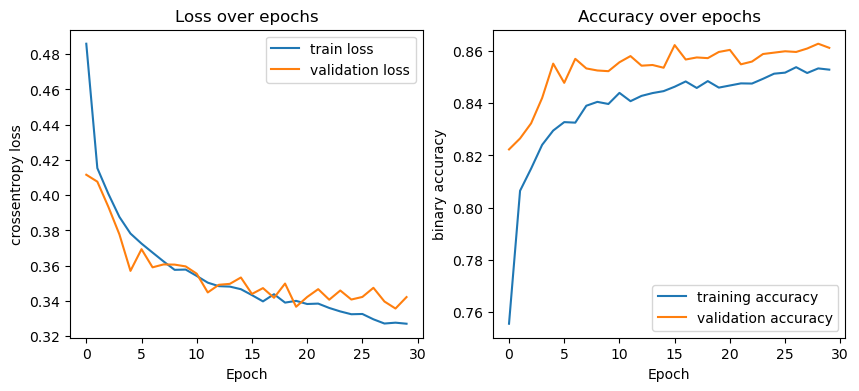

model validation accuracy: 0.8627760410308838
Model with 32 nodes, dropout 0.1, batch size 64 trained.


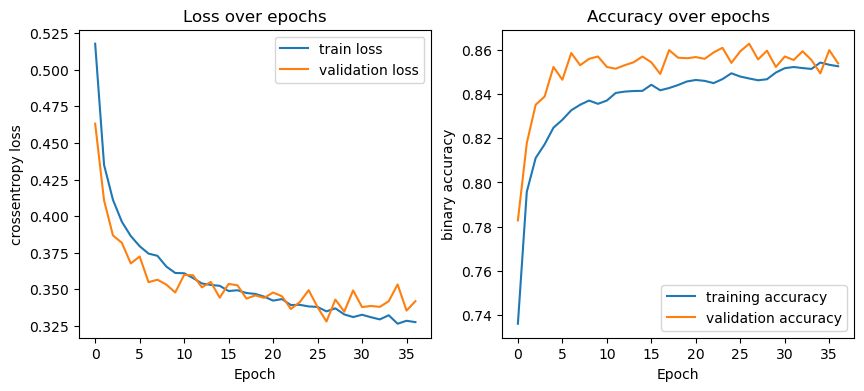

model validation accuracy: 0.8627760410308838
Model with 32 nodes, dropout 0.1, batch size 128 trained.


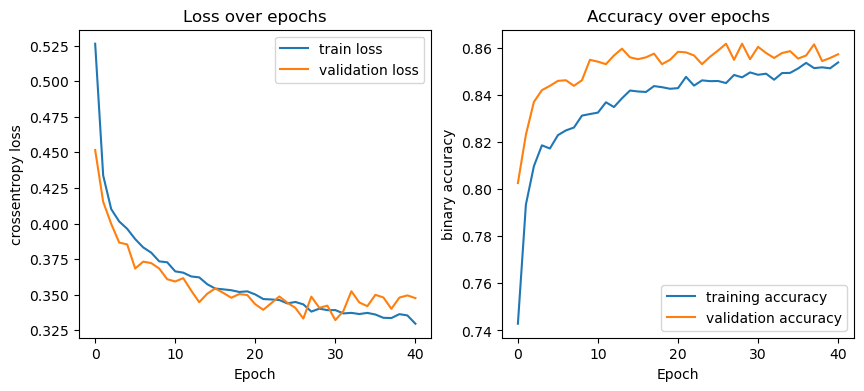

model validation accuracy: 0.8617244958877563
Model with 32 nodes, dropout 0.2, batch size 32 trained.


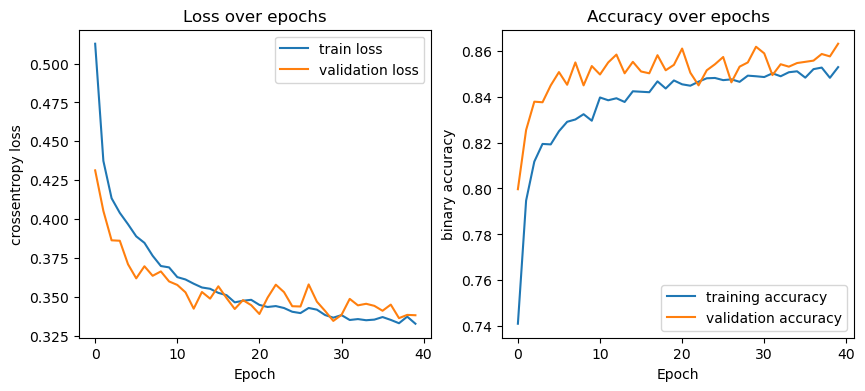

model validation accuracy: 0.8630388975143433
Model with 32 nodes, dropout 0.2, batch size 64 trained.


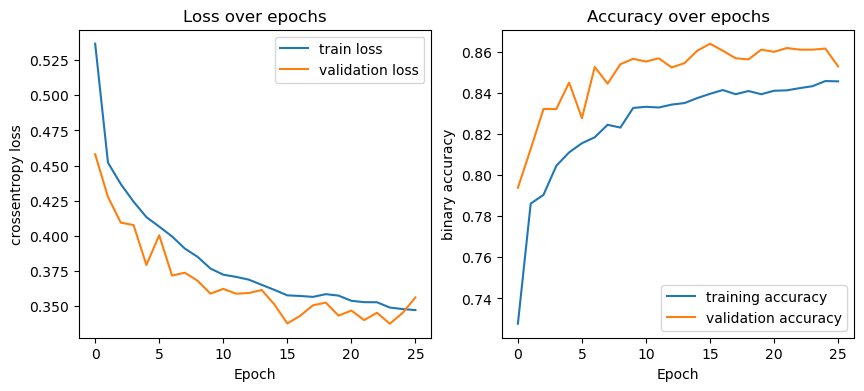

model validation accuracy: 0.8640904426574707
Model with 32 nodes, dropout 0.2, batch size 128 trained.


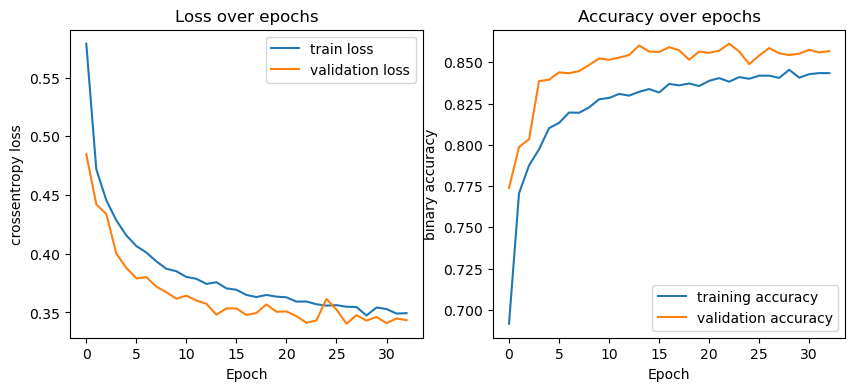

model validation accuracy: 0.8611987233161926
Model with 64 nodes, dropout 0.1, batch size 32 trained.


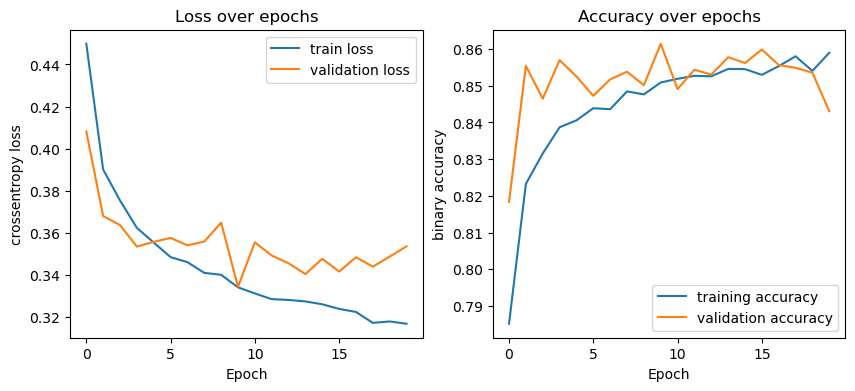

model validation accuracy: 0.8614616394042969
Model with 64 nodes, dropout 0.1, batch size 64 trained.


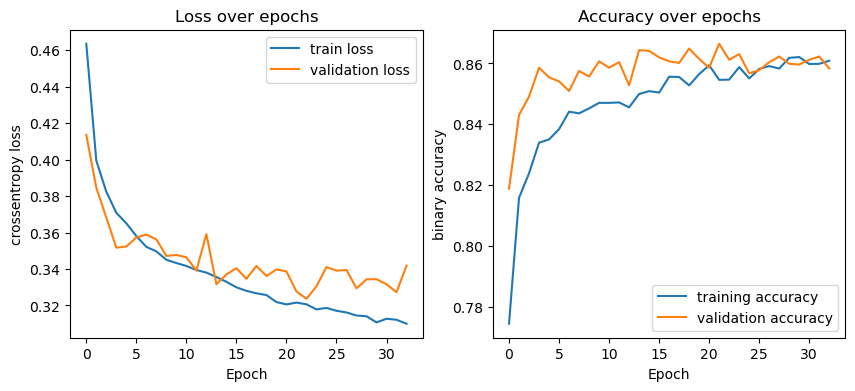

model validation accuracy: 0.8664563894271851
Model with 64 nodes, dropout 0.1, batch size 128 trained.


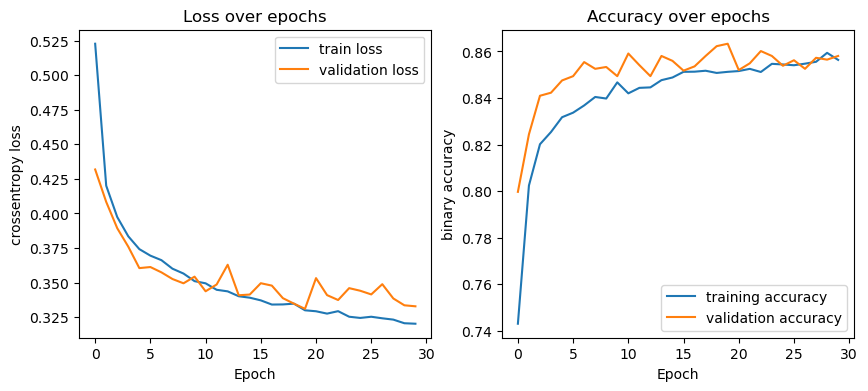

model validation accuracy: 0.8633018136024475
Model with 64 nodes, dropout 0.2, batch size 32 trained.


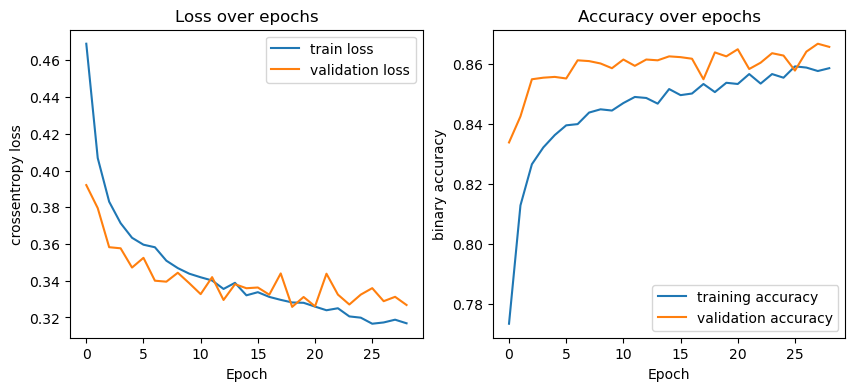

model validation accuracy: 0.8667192459106445
Model with 64 nodes, dropout 0.2, batch size 64 trained.


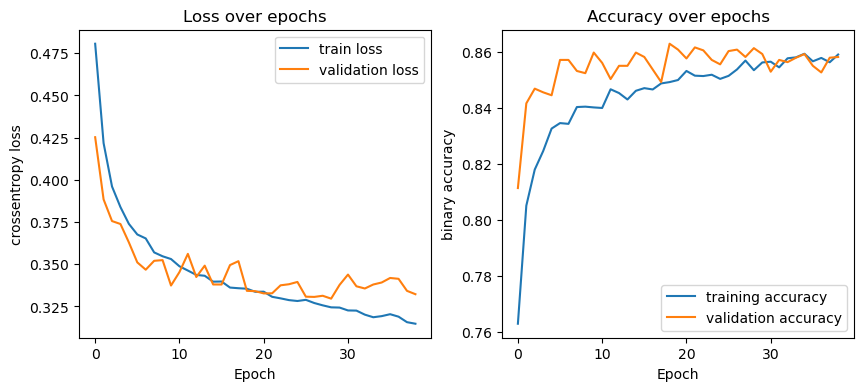

model validation accuracy: 0.8630388975143433
Model with 64 nodes, dropout 0.2, batch size 128 trained.


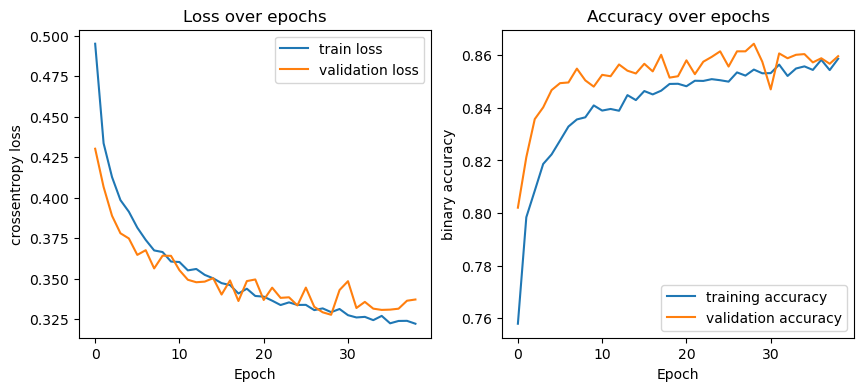

model validation accuracy: 0.8643532991409302
Model with 128 nodes, dropout 0.1, batch size 32 trained.


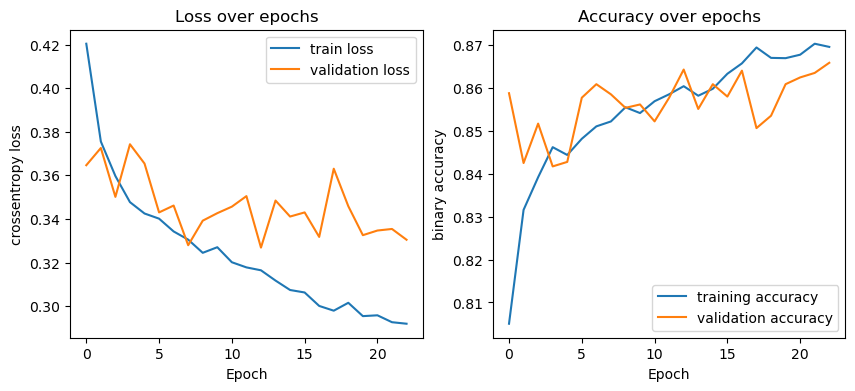

model validation accuracy: 0.8659306168556213
Model with 128 nodes, dropout 0.1, batch size 64 trained.


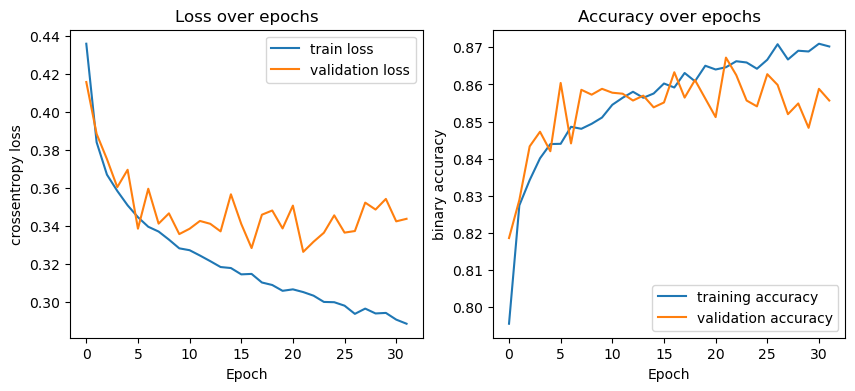

model validation accuracy: 0.8672450184822083
Model with 128 nodes, dropout 0.1, batch size 128 trained.


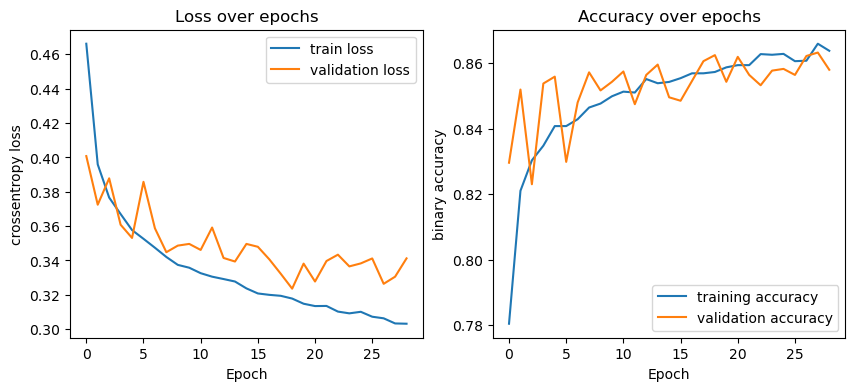

model validation accuracy: 0.8633018136024475
Model with 128 nodes, dropout 0.2, batch size 32 trained.


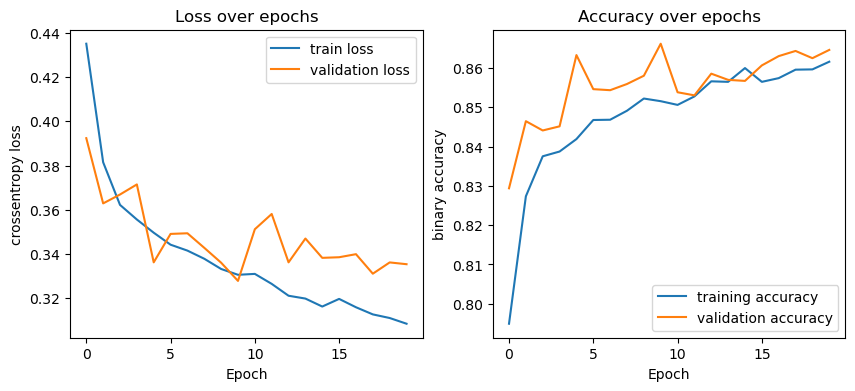

model validation accuracy: 0.8661934733390808
Model with 128 nodes, dropout 0.2, batch size 64 trained.


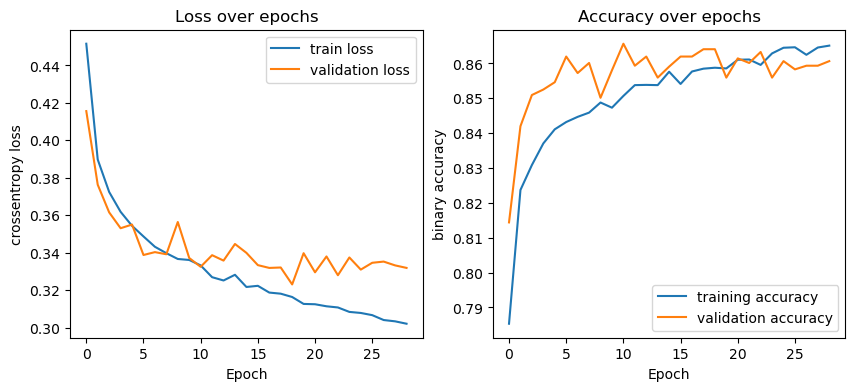

model validation accuracy: 0.8656677007675171
Model with 128 nodes, dropout 0.2, batch size 128 trained.


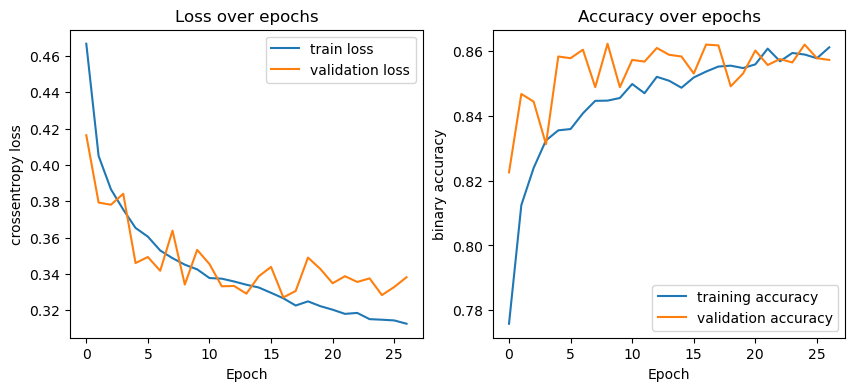

model validation accuracy: 0.8622502684593201


In [64]:
least_val_loss = float('inf')  # to record what model has the least validation loss
best_model = None  # to store the best model (with the least validation loss)
epochs = 100
for num_nodes in [32, 64, 128]:
    for dropout_prob in [0.1, 0.2]:
        for batch_size in [32, 64, 128]:
            print(f"Model with {num_nodes} nodes, dropout {dropout_prob}, batch size {batch_size} trained.")
            model, history = train_nn_model_stopping(X_train, y_train, num_nodes, dropout_prob, epochs, batch_size, X_valid, y_valid)
            plot_history(history)
            print(f"model validation accuracy: {max(history.history['val_binary_accuracy'])}")
            # Check if this model is the best so far
            val_loss, val_accuracy = model.evaluate(X_valid, y_valid, verbose=0)  # Evaluate each model on the validation set
            if val_loss < least_val_loss:
                least_val_loss = val_loss
                best_model = model

In [68]:
y_predict= best_model.predict(X_test)
y_predict= (y_predict > 0.5).astype('int').flatten()  # Convert probabilities to binary predictions
y_predict

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


array([0, 1, 0, ..., 0, 1, 1])

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1355
           1       0.89      0.92      0.91      2449

    accuracy                           0.88      3804
   macro avg       0.87      0.86      0.86      3804
weighted avg       0.88      0.88      0.88      3804



## The predictions
- The best prediction I got was by using Neural Network model that gave an accuracy of 88% 
- The second model with the best accuracy was the SVM with 86% accuracy